In [1]:
import numpy as np
import tensorflow as tf
import t3f
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from gptt_embed.gpstruct import TTGPstruct
from gptt_embed import grid
from gptt_embed.covariance import SE_multidim
from gptt_embed.projectors import Identity
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Data Loading

In [4]:
x_tr = np.load('data_struct_embed/x_tr.npy')
x_te = np.load('data_struct_embed/x_te.npy')
y_tr = np.load('data_struct_embed/y_tr.npy')
y_te = np.load('data_struct_embed/y_te.npy')

In [5]:
x_tr.shape

(100, 3, 2)

In [6]:
D = x_tr.shape[-1]

In [7]:
x_tr_flat = x_tr.reshape([-1, D])
x_te_flat = x_te.reshape([-1, D])

In [8]:
scaler = StandardScaler()
x_tr_flat = scaler.fit_transform(x_tr_flat)/3
x_te_flat = scaler.transform(x_te_flat)/3

In [9]:
x_tr = x_tr_flat.reshape(x_tr.shape)
x_te = x_te_flat.reshape(x_te.shape)

In [10]:
x_tr[x_tr > 1] = 1
x_tr[x_tr < -1] = -1
x_te[x_te > 1] = 1
x_te[x_te < -1] = -1

In [11]:
max_len = x_tr.shape[1]
n_labels = 4
n_seq = x_tr.shape[0]

## GP

In [12]:
num = 10
inputs = grid.InputsGrid(D, left=-1., right=1., npoints=num)
projector = Identity(D)
cov = SE_multidim(n_labels, .7, .3, .1, projector)

In [13]:
mu_ranks = 5
gp = TTGPstruct(cov, inputs, mu_ranks)

## Graph Creation

In [14]:
seq_lens = np.ones(shape=(n_seq,)) * max_len

In [15]:
x_tr = tf.constant(x_tr)
x_te = tf.constant(x_te)
y_tr = tf.constant(y_tr)
y_te = tf.constant(y_te)
seq_lens = tf.constant(seq_lens)

In [16]:
N = n_seq
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(1e-2, global_step, 
                                        50, 0.5, staircase=True)

In [17]:
elbo_op, train_op = gp.fit(x_tr, y_tr, seq_lens, N, lr, global_step)

_latent_vars_distribution/x_flat (?, 2) = sum_len x 2
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 4
cov_for_squared_dists/cov (4, 100, 3, 3) = [4, 100, 3, 3]
_Knns/K_nn (4, 100, 3, 3) = 4 x 100 x 3 x 3
_sample_f/f_un (4, 100, 3) = 4 100 3
_sample_f/f_bin (16,) = 16


## Learning

In [18]:
sess = tf.Session()
gp.initialize(sess)
sess.run(tf.global_variables_initializer())

In [19]:
maxiter = 300
elbo_vals = []
for i in range(maxiter):
    _, elbo = sess.run([train_op, elbo_op])
    print(elbo)
    elbo_vals.append(elbo)

4408.58045045
4273.91385019
4137.10574592
4008.72755217
3888.08499065
3770.81145711
3657.77163053
3550.5442148
3448.26517178
3351.07730904
3259.62764823
3169.7329038
3085.62611601
3002.22020869
2927.83003821
2852.02253876
2781.39492818
2713.47252022
2650.12361974
2587.4911309
2527.202826
2469.76638225
2414.93479538
2363.61894713
2312.09213258
2264.87053069
2220.06507809
2175.41445259
2132.08829707
2089.61508579
2051.67912871
2013.2931993
1976.6302155
1942.27330715
1906.40636133
1874.19727499
1843.99218111
1813.50840439
1783.15488887
1753.22582983
1726.29832529
1699.96110102
1673.30215149
1648.05073585
1623.01104932
1601.86139484
1577.61174205
1555.52972882
1532.72162531
1513.32738289
1491.78582611
1481.52707607
1473.63342276
1463.95432278
1453.26086738
1443.44619685
1435.10861017
1425.67425175
1416.63712249
1409.01888538
1399.35965854
1391.65694457
1382.18735116
1374.4176936
1365.47447081
1356.81812517
1350.02976544
1342.57942593
1334.19062808
1326.92683513
1317.9928858
1310.68191125
1

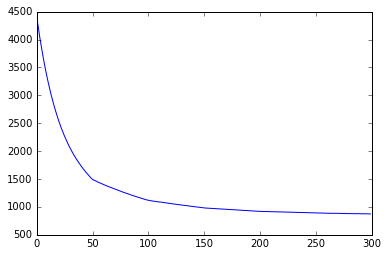

In [20]:
plt.plot(elbo_vals)

In [24]:
bin_mu = sess.run(gp.bin_mu)

In [25]:
for i in range(4):
    for j in range(4):
        print(i, j, bin_mu[i * 4 + j])

0 0 0.576291190267
0 1 0.226665580064
0 2 -0.459092713189
0 3 -0.593079039897
1 0 -0.42196340216
1 1 0.422851331173
1 2 0.534951570405
1 3 -0.563292794294
2 0 -0.449503796348
2 1 -0.533376093607
2 2 0.209494048348
2 3 0.306165229159
3 0 0.468661402216
3 1 -0.507516727564
3 2 -0.577363059337
3 3 0.278847117815


## Prediction

In [21]:
seq_lens_te = tf.constant(np.ones([x_te.shape[0]]) * max_len)

In [22]:
preds = gp.predict(x_te, seq_lens_te, sess)

_latent_vars_distribution/x_flat (?, 2) = sum_len x 2
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 4
cov_for_squared_dists/cov (4, 50, 3, 3) = [4, 50, 3, 3]
_Knns/K_nn (4, 50, 3, 3) = 4 x 50 x 3 x 3


In [23]:
np.sum(sess.run(y_te) == preds) / preds.size

0.95333333333333337

In [25]:
sess.close()